# Results using 220-gene spatial aging clocks after removing higher spillover rate genes

A common concern in imaging-based single-cell transcriptomics is the potential misallocation of transcripts between nearby cell segmentations. One of the approaches to adjust for these issues across our analyses is to filter out genes that have higher estimated spillover rate (determined using an interval Vizgen metric). This notebook contains code for generating some of the main results from the manuscript using the spatial aging clocks trained on these 220 genes.

**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20_minus80.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions after cross-validated training on 220 genes (generated from `cv_train_clock.py` with "spatial_smooth_minus80" argument)
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_minus80_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks trained on the 220 genes (generated from `full_train_clock.py` with "spatial_smooth_minus80" argument)
- `data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad` - AnnData object for exercise dataset
- `data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad` - AnnData object for reprogramming dataset
- assorted AnnData objects corresponding to external datasets from Allen et al. (2022), Zeng et al. (2023) and reformatted according to steps in Methods section of manuscript 

**Conda environment used**: `requirements/merfish.txt`


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree
import json

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *
from clock_preprocessing import *
from clock_prediction import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

celltype_palette = {'Neuron-Excitatory':'forestgreen',
                    'Neuron-Inhibitory':'lightgreen', 
                    'Neuron-MSN':'yellowgreen',
                    'Astrocyte': 'royalblue', 
                    'Microglia': 'aqua', 
                    'Oligodendrocyte': 'skyblue', 
                    'OPC': 'deepskyblue',
                    'Endothelial': 'red', 
                    'Pericyte': 'darkred', 
                    'VSMC': 'salmon', 
                    'VLMC': 'indianred',
                    'Ependymal': 'gray', 
                    'Neuroblast': 'sandybrown', 
                    'NSC':'darkorange', 
                    'Macrophage':'purple', 
                    'Neutrophil':'darkviolet',
                    'T cell':'magenta', 
                    'B cell':'orchid',
}

# function for bootstrap sampling for statistics
def bootstrap_median_difference (df1, df2, ci=0.95, num_boot=1000):
    '''
    Given two dataframes with mouse_id and pred_age as columns, computes bootstrap confidence interval.
    Bootstrap samples by mouse_id within each dataframe separately.
    Computes difference of medians df1-df2.
    Computes confidence interval for these differences.
    '''
    med_diffs = []
    for i in range(num_boot):
        
        boot_df1_stacks = []
        draw1 = np.random.choice(np.unique(df1["mouse_id"].values), len(np.unique(df1["mouse_id"].values)), replace=True)
        for d1 in draw1:
            boot_df1_stacks.append(df1[df1["mouse_id"]==d1].copy())
        
        boot_df2_stacks = []
        draw2 = np.random.choice(np.unique(df2["mouse_id"].values), len(np.unique(df2["mouse_id"].values)), replace=True)
        for d2 in draw2:
            boot_df2_stacks.append(df2[df2["mouse_id"]==d2].copy())
        
        boot_df1 = pd.concat(boot_df1_stacks)
        boot_df2 = pd.concat(boot_df2_stacks)
        med_diffs.append(boot_df1["pred_age"].median() - boot_df2["pred_age"].median())
    
    # confidence interval
    lower = np.quantile(med_diffs, 0.025)
    upper = np.quantile(med_diffs, 0.975)
    
    return((lower,upper))

In [3]:
# CUSTOM Pink-Green colormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

# create colormap
# ---------------

# number of shades to cut in
cut_in = round(0.04*256)

# set side colormaps
upper = matplotlib.cm.PiYG_r(np.arange(256))

# create middle colormap
lower1 = np.ones((int(256/4),4))
lower2 = np.ones((int(256/4),4))
ulen = round(upper.shape[0]/2)
for i in range(3):
    lower1[:,i] = np.linspace(1, upper[ulen-cut_in,i], lower1.shape[0])
    lower2[:,i] = np.linspace(1, upper[ulen+cut_in,i], lower2.shape[0])

# combine parts of colormap
cmap = np.vstack((upper[:ulen-cut_in,:], lower1[::-1], lower2, upper[ulen+cut_in:,:]))

# convert to matplotlib colormap
cmap = matplotlib.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

## Spatial aging clocks performance

Evaluate the performance of spatial aging clocks trained on the 220 genes

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20_minus80.h5ad")

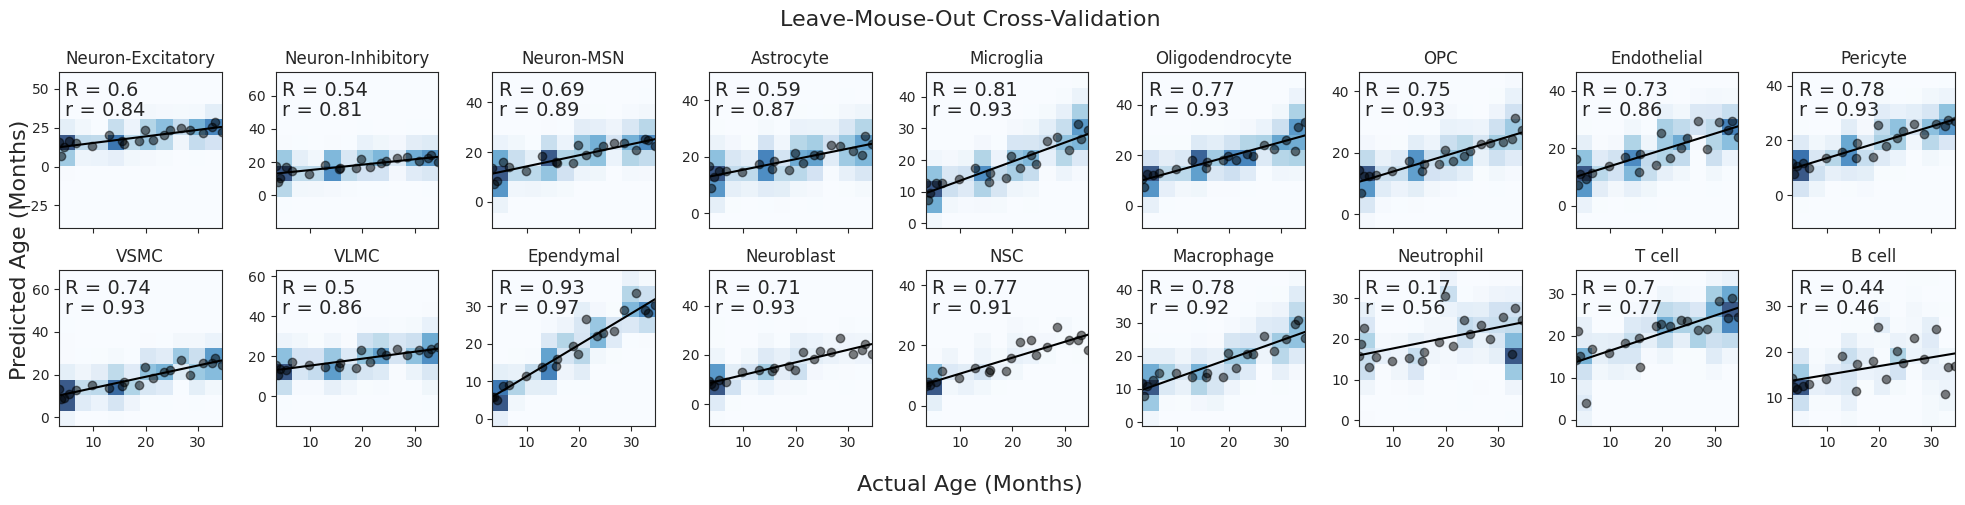

In [5]:
nrows = 2
ncols = 9

fig, axs = plt.subplots(2, 9, figsize=(20,5), sharex=True, sharey=False)

celltype_list = []
r_list = []
r_list_median = []
mae_list = []

counter = 0
for i in range(nrows):
    for j in range(ncols):
        
        celltype = list(pd.unique(adata.obs.celltype).sort_values())[counter]
        sub_adata = adata[adata.obs["celltype"]==celltype,:]
        
        # make plot
        axs[i,j].hist2d(sub_adata.obs['age'], sub_adata.obs['predicted_age'], alpha=0.8, cmap='Blues', bins=10)
        axs[i,j].scatter(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), c='k', alpha=0.5)
        b, a = np.polyfit(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median(), deg=1)
        xseq = np.linspace(np.min(sub_adata.obs['age']),np.max(sub_adata.obs['age']),100)
        axs[i,j].plot(xseq, a + b * xseq, color="k")
        axs[i,j].set_title(celltype)
        r,p = pearsonr(sub_adata.obs['age'], sub_adata.obs['predicted_age'])
        r_med,p_med = pearsonr(sub_adata.obs.groupby(["mouse_id"])["age"].median(), sub_adata.obs.groupby(["mouse_id"])["predicted_age"].median())
        mae = np.mean(np.abs(sub_adata.obs['age']-sub_adata.obs['predicted_age']))
        #axs[i,j].annotate(f"R = {round(r,2)}", (0.3, 0.05), xycoords='axes fraction', fontsize=14)
        axs[i,j].annotate(f"R = {round(r,2)}", (0.04, 0.85), xycoords='axes fraction', fontsize=14)
        axs[i,j].annotate(f"r = {round(r_med,2)}", (0.04, 0.72), xycoords='axes fraction', fontsize=14)
        
        # append stats
        celltype_list.append(celltype)
        r_list.append(r)
        mae_list.append(mae)
        r_list_median.append(r_med)
        
        counter += 1

# make figure
fig.suptitle("Leave-Mouse-Out Cross-Validation", fontsize=16)
fig.supxlabel("Actual Age (Months)", fontsize=16)
fig.supylabel("Predicted Age (Months)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/clocks/pseudobulked/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_minus80.pdf",
            bbox_inches='tight')
plt.show()


# save stats
stat_df = pd.DataFrame(np.vstack([celltype_list, r_list, r_list_median, mae_list]).T, columns=["celltype", "pearson", "pearson_median", "mean_abs_err"])
stat_df.to_csv("results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20_minus80.csv", index=False)

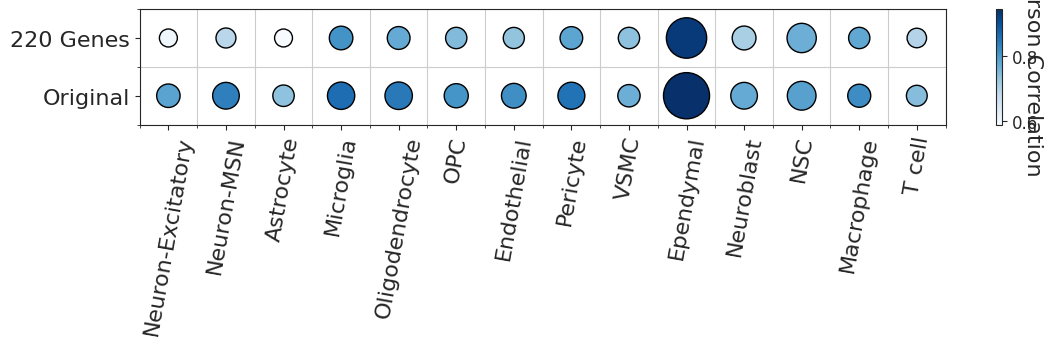

In [7]:
# PRINT OUT LABELS FOR SIZE LEGEND


filepaths = ["results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.csv",
             "results/clocks/stats/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20_minus80.csv"]
names = ["Original", "220 Genes"]

celltypes = restricted_celltype_subset

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###############################################
df_list = []

for i, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath)
    df["name"] = names[i]
    df["celltype"] = df["celltype"].astype('category').cat.reorder_categories(celltypes_full)
    df = df.sort_values(by="celltype")
    df = df[df["celltype"].isin(celltypes)]
    if list(df["celltype"]) != celltypes:
        print("Warning: celltype order not matching up for "+filepath)
    df_list.append(df)
    
comb_df = pd.concat(df_list)

##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(filepaths)
M = len(celltypes)
ylabels = names
xlabels = celltypes

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = 1/comb_df["mean_abs_err"].values
c = comb_df["pearson"].values

fig, ax = plt.subplots(figsize=(13,1.5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=80, fontsize=16)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


plt.savefig("plots/clocks/comparison_train_test_same_Leaky.pdf", bbox_inches='tight')
plt.show()

# Evaluation on validation and interventions datasets

Applying 220-gene spatial aging clocks to the four main intervention datasets.

## Exercise (MERFISH 300 genes)

In [15]:
adata = sc.read_h5ad("data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="0")].copy()

In [16]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_minus80"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
Neutrophil
OPC
Oligodendrocyte
Pericyte
T cell
VLMC
VSMC


In [17]:
df.to_csv(f"results/clocks/applied/exercise_spatialsmooth_minus80.csv")
adata.write_h5ad("results/clocks/anndata/exercise_spatialsmooth_minus80.h5ad")

In [7]:
df = pd.read_csv(f"results/clocks/applied/exercise_spatialsmooth_minus80.csv")

df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.43229898/ipykernel_19955/667864559.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


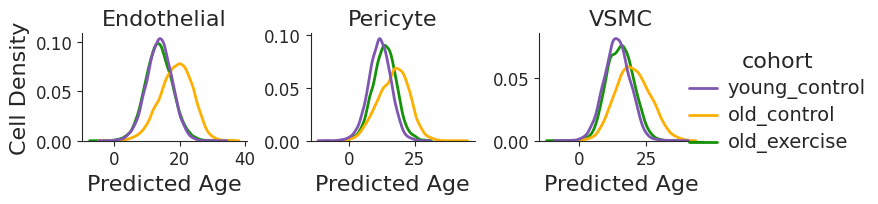

In [25]:
# Plot predicted age densities across select cell types

palette = {"young_control":"#7F57B2",
           "old_exercise":"#149309",
           "old_control":"#FEAF00"}

sub_df = df[df["celltype"].isin(["Endothelial","Pericyte","VSMC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

ncols = 3

g = sns.displot(data=sub_df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=6/ncols, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["young_control", "old_control", "old_exercise"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.show()

In [8]:
# compute stats

celltypes = ["Endothelial","Pericyte","VSMC"]
comparisons = [["old_exercise", "old_control"],
               ["old_exercise", "young_control"],
               ["old_control", "young_control"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
-5.56
-0.218
5.35
-3.69
1.87
5.56
-4.47
1.27
5.74

DIFF LOWER:
-9.02
-2.15
1.92
-7.04
-0.434
0.198
-10.8
-1.64
1.53

DIFF UPPER:
-1.8
2.2
8.36
1.46
4.77
8.83
0.405
4.39
11.6


/local/scratch/edsun/slrmtmp.43229898/ipykernel_19955/3434821769.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")


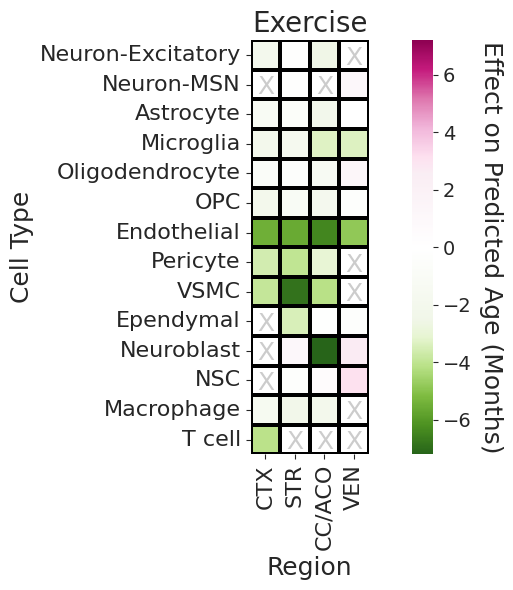

In [27]:
# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]

region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

# fingerprint heatmap
effect_cutoff = 0

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = pd.unique(df["region_coarse"]).sort_values()
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)].copy()
        if sub_df[sub_df['cohort']=="old_exercise"].shape[0] < 50: # if less than certain number of cells in region+oldtreated group
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="old_exercise"]["pred_age"].median() - sub_df[sub_df['cohort']=="old_control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region_coarse"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region_coarse"] = start_df["region_coarse"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Exercise", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.show()

## Partial Reprogramming (MERFISH 300 genes)

In [4]:
adata = sc.read_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="0")].copy()

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_minus80"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Neuron-MSN


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


OPC
Oligodendrocyte
Pericyte
VLMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


VSMC


In [6]:
df.to_csv(f"results/clocks/applied/reprogramming_spatialsmooth_minus80.csv")
adata.write_h5ad("results/clocks/anndata/reprogramming_spatialsmooth_minus80.h5ad")

In [9]:
df = pd.read_csv(f"results/clocks/applied/reprogramming_spatialsmooth_minus80.csv")

df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

In [10]:
# correct for difference in ages between treatment and control
mean_oc_age = np.mean(np.unique(df[df.cohort=="old_notreatment"].age))
mean_ot_age = np.mean(np.unique(df[df.cohort=="old_treatment"].age))
print(mean_oc_age)
print(mean_ot_age)

pred_ages = df["pred_age"].values.copy()
pred_ages[df.cohort=="old_notreatment"] += (mean_ot_age-mean_oc_age)
df["pred_age"] = pred_ages

27.425
27.724999999999998


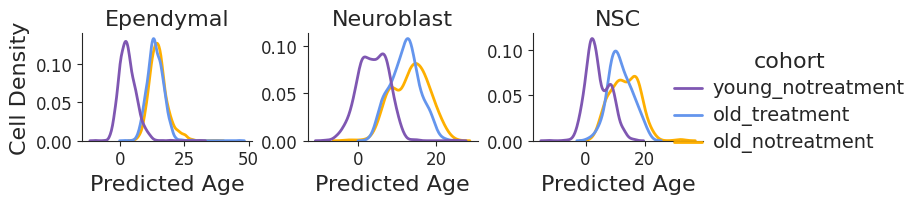

In [9]:
# SUBSET TOP 3

palette = {"young_notreatment":"#7F57B2",
           "old_treatment":"cornflowerblue", # #149309
           "old_notreatment":"#FEAF00"}

sub_df = df[df["celltype"].isin(["Ependymal","Neuroblast","NSC"])].copy()
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

ncols = 3
g = sns.displot(data=sub_df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=6/ncols, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["young_notreatment", "old_treatment", "old_notreatment"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.show()

In [11]:
# compute stats

celltypes = ["Ependymal","Neuroblast","NSC"]
comparisons = [["old_treatment", "old_notreatment"],
               ["old_treatment", "young_notreatment"],
               ["old_notreatment", "young_notreatment"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
-0.915
11.0
11.9
-1.56
8.43
9.99
-1.83
7.84
9.67

DIFF LOWER:
-2.33
8.73
9.4
-5.15
4.42
3.25
-6.94
2.39
2.73

DIFF UPPER:
0.988
12.9
13.7
3.9
11.9
14.4
5.13
12.5
14.8


/local/scratch/edsun/slrmtmp.43229898/ipykernel_25441/1336754727.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")


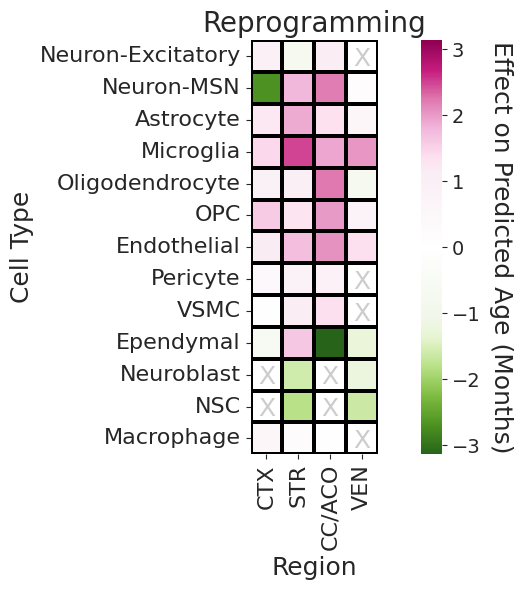

In [11]:
# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]

region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

# fingerprint heatmap
effect_cutoff = 0

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = pd.unique(df["region_coarse"]).sort_values()
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)].copy()
        if sub_df[sub_df['cohort']=="old_treatment"].shape[0] < 50: # if less than certain number of cells in region+oldtreated group
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="old_treatment"]["pred_age"].median() - sub_df[sub_df['cohort']=="old_notreatment"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region_coarse"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region_coarse"] = start_df["region_coarse"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Reprogramming", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.show()

## Allen et al. (2022) + LPS

In [4]:
adata = sc.read_h5ad("data/allen_2022_aging_merfish/merfish_combined_processed_umap.h5ad")
adata.obs["region"] = adata.obs.tissue.copy()

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_minus80"
df = get_predictions(adata, clock_obj_name=name, normalize=False, standardize=False, fill_missing="spage")

Astrocyte
Imputing values for 174 missing genes
Endothelial
Imputing values for 174 missing genes
Macrophage
Imputing values for 174 missing genes
Microglia
Imputing values for 174 missing genes
Neuron-Excitatory
Imputing values for 174 missing genes
Neuron-Inhibitory
Imputing values for 174 missing genes
Neuron-MSN
Imputing values for 174 missing genes
OPC
Imputing values for 174 missing genes
Oligodendrocyte
Imputing values for 174 missing genes
Pericyte
Imputing values for 174 missing genes
T cell
Imputing values for 174 missing genes
VLMC
Imputing values for 174 missing genes


In [6]:
df.to_csv(f"results/clocks/applied/allen_aging_lps_spatialsmooth_spage_minus80.csv")
adata.write_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_spage_minus80.h5ad")

In [12]:
df = pd.read_csv(f"results/clocks/applied/allen_aging_lps_spatialsmooth_spage_minus80.csv")


df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

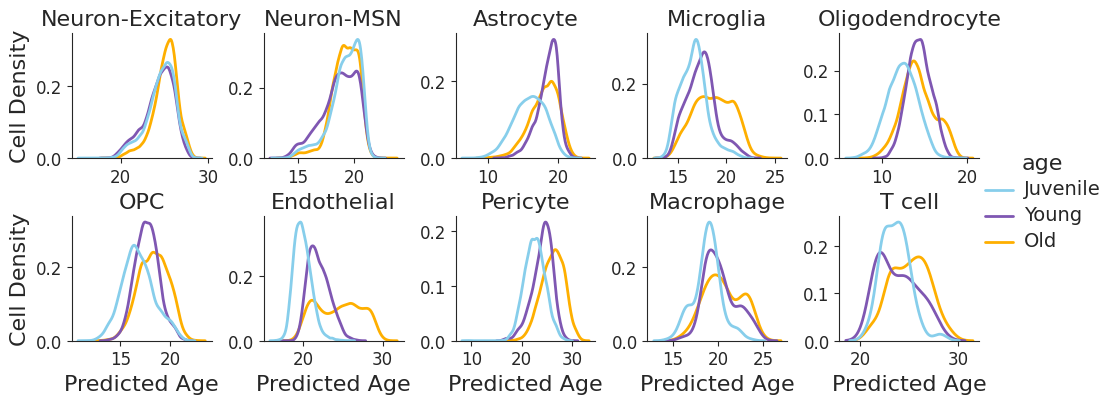

In [8]:
df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

palette = {"Young":"#7F57B2",
           "Juvenile":"#87CEEB",
           "Old":"#FEAF00"}

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=10/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Juvenile", "Young", "Old"], linewidth=2, common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.show()

In [13]:
df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)
df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

# compute stats

celltypes = ["Neuron-Excitatory", "Neuron-MSN", "Astrocyte", "Microglia",
             "Oligodendrocyte", "OPC", "Endothelial", "Pericyte",
             "Macrophage", "T cell"]
comparisons = [["Old", "Juvenile"],
               ["Old", "Young"],
               ["Young", "Juvenile"]]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_aging[df_aging["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
0.459
0.661
-0.202
-0.137
0.408
-0.545
2.15
-0.537
2.69
2.04
1.25
0.794
1.67
-0.257
1.93
1.67
0.707
0.96
4.75
2.78
1.97
3.7
1.9
1.8
1.44
0.43
1.01
1.6
1.52
0.0868

DIFF LOWER:
0.291
0.371
-0.52
-0.513
0.0342
-0.936
1.37
-0.955
1.96
1.54
0.66
0.29
0.467
-1.22
0.982
1.21
0.275
0.672
2.36
0.162
1.35
2.32
0.697
0.78
0.366
-0.818
0.293
-0.00354
-0.747
-1.92

DIFF UPPER:
0.651
0.983
0.14
0.234
0.798
-0.214
2.75
-0.117
3.33
2.55
1.75
1.33
3.17
1.06
2.84
2.2
1.18
1.25
6.68
4.8
2.83
5.02
3.11
2.71
2.49
1.64
1.77
3.01
3.79
2.05


/local/scratch/edsun/slrmtmp.43229898/ipykernel_26117/4158927820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


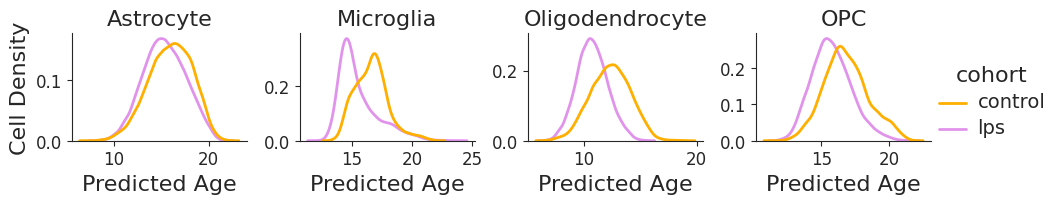

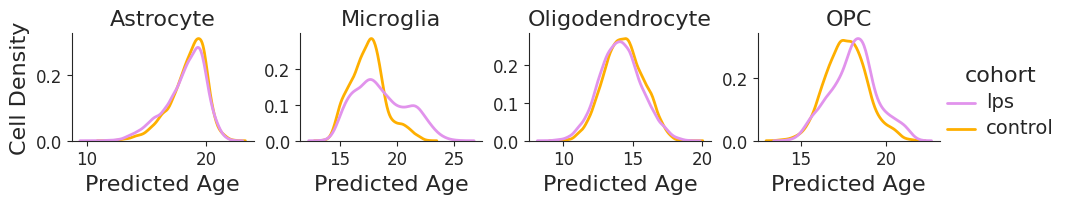

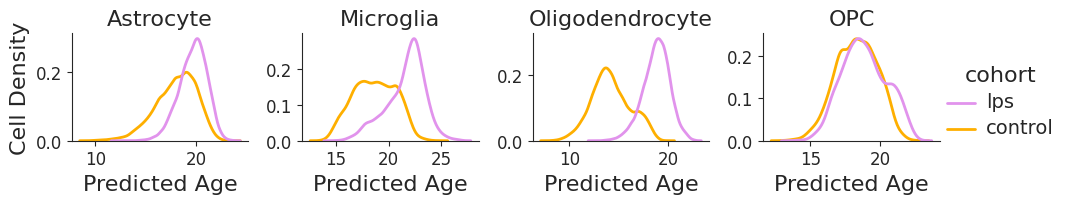

In [10]:
# TOP 4 SUBSET

sub_df = df[df["celltype"].isin(["Astrocyte","Microglia","Oligodendrocyte","OPC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

for age in np.unique(sub_df['age']):
    df_lps = sub_df[sub_df['age']==age].copy()
    df_lps = df_lps.replace('aging', 'control')

    palette = {"control":"#FEAF00",
           "lps":"#E193EC"} # #E193EC

    ncols = 4
    g = sns.displot(data=df_lps[df_lps['age']==age], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                linewidth=2, common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.show()

In [14]:
# compute stats

df_lps = df[df['age']==20.93]

celltypes = ["Astrocyte","Microglia","Oligodendrocyte","OPC"]
comparisons = [["lps", "aging"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_lps[df_lps["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
1.57
3.28
4.84
0.429

DIFF LOWER:
1.01
2.25
3.39
-0.285

DIFF UPPER:
2.08
3.95
5.78
1.44


/local/scratch/edsun/slrmtmp.43229898/ipykernel_26117/999176281.py:50: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


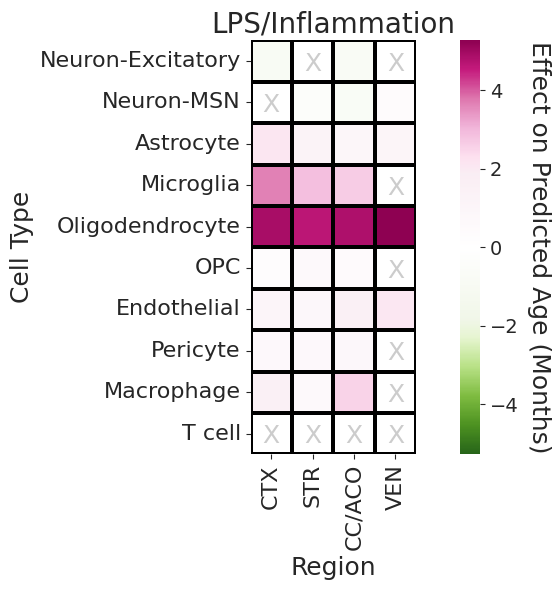

In [12]:
# OLD region-specific intervention effect


coarse_region_mapping = {
    "corpus callosum":"CC/ACO",
    "olfactory region":"CC/ACO",
    "cortical layer II/III":"CTX",
    "cortical layer V":"CTX",
    "cortical layer VI":"CTX",
    "pia mater":"CTX",
    "striatum":"STR",
    "brain ventricle":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]
df['age'] = df['age'].astype(str)
df['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df['age']]


# fingerprint heatmap
effect_cutoff = 0


region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region_coarse"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)&(df['age']=='Old')].copy()
        sub_df = sub_df.replace('aging', 'control')
        if sub_df[sub_df['cohort']=="lps"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="lps"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("LPS/Inflammation", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
# plt.savefig("plots/clocks/allen_spatialsmooth_heatmap_medians_REGIONED_Old_spage_minus11.pdf",
#             bbox_inches='tight')
plt.show()

## Zeng et al. (2023) - Alzheimer's

In [4]:
adata = sc.read_h5ad("data/zeng_2023_alzheimer_starmap/starmap_AD_processed.h5ad")
adata.obsm['spatial'] = adata.obs[["X","Y"]].values
adata.obs["region"] = adata.obs.region_merged.copy()

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_minus80"
df = get_predictions(adata, clock_obj_name=name, fill_missing="spage")

Astrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
Endothelial


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 111 missing genes


In [6]:
df.to_csv(f"results/clocks/applied/zeng_starmapAD_spatialsmooth_spage_minus80.csv")
adata.write_h5ad("results/clocks/anndata/zeng_starmapAD_spatialsmooth_spage_minus80.h5ad")

In [15]:
df = pd.read_csv(f"results/clocks/applied/zeng_starmapAD_spatialsmooth_spage_minus80.csv")


df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.43229898/ipykernel_27995/1268128983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


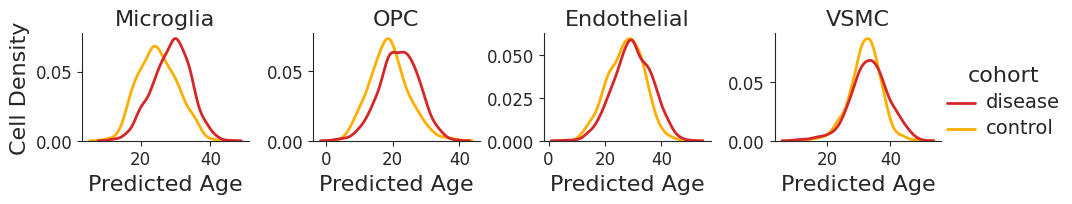

In [8]:
# TOP 4 SUBSET (13 months)

sub_df = df[df["celltype"].isin(["Microglia","OPC","Endothelial","VSMC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

palette = {"control":"#FEAF00", # #935E09
           "disease":"tab:red"}
ncols = 4
g = sns.displot(data=sub_df[sub_df['age']==13], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            linewidth=2, common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.show()

In [16]:
df_ad = df[df['age']==13]


celltypes = ["Microglia","OPC","Endothelial","VSMC"]
comparisons = [["disease", "control"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_ad[df_ad["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
4.56
3.52
2.04
1.05

DIFF LOWER:
2.42
0.342
0.3
-1.06

DIFF UPPER:
6.54
6.31
4.01
4.28


/local/scratch/edsun/slrmtmp.43229898/ipykernel_27995/3024893079.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


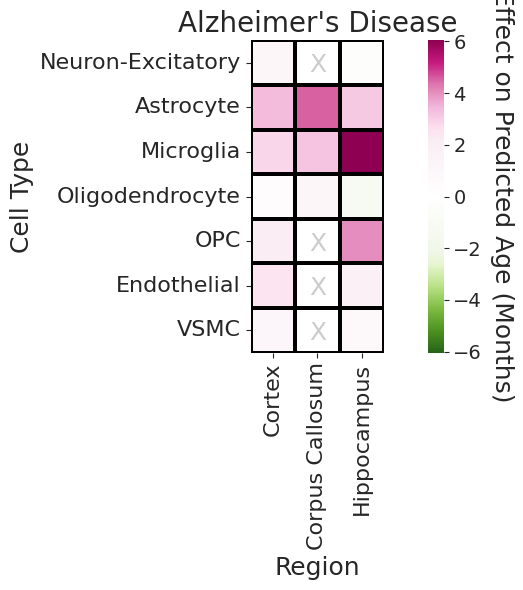

In [10]:
# fingerprint heatmap
effect_cutoff = 0

region_order = ['Cortex', 'Corpus Callosum', 'Hippocampus']

celltypes = pd.unique(df["celltype"]).sort_values()
df["region"] = df["region"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region']==reg)&(df['age']==13)].copy()
        if sub_df[sub_df['cohort']=="disease"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="disease"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Alzheimer's Disease", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.show()

# Proximity effects

Compute proximity effects using the 220-gene spatial aging clocks to predicte age and compuate age acceleration

In [4]:
# Distance Cutoff Parameters -- see 5A_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

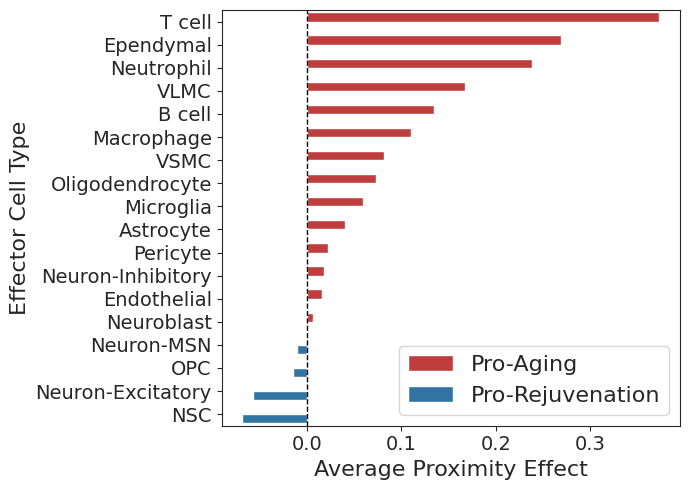

In [5]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20_minus80.h5ad")

##################################################

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        
        

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_minus80.pdf",
            bbox_inches='tight')
plt.show()